In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from an .env file
load_dotenv()

True

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
pd.set_option('display.max_rows', 100)  # You can set this to any number
pd.set_option('display.max_columns', 50)  # You can set this to any number

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_data_from_db(connection_string, query):
    engine = create_engine(connection_string)
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)
    return df

In [4]:
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

In [5]:
connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}/{db_name}'

In [6]:
df = load_data_from_db(connection_string, """select * from feature_set limit 250000""")

# Select cards with non-zero prices
- $20+

In [7]:
df = df.loc[(df.product_type == "card") & (df.price != 0)]
df.shape

(165318, 36)

In [8]:
df = df.loc[df.price>=20]

In [9]:
df.card_type.value_counts()

# Missing significant number of card types - i.e. should be far less NaNs. Need to scrape 2nd set pages of psa's website as soon as their Public API back up

card_type
NaN                          88190
full art                      1020
full art secret                698
illustration rare              188
special illustration rare       92
shiny ultra rare                31
ultra rare                      24
hyper rare                      18
Name: count, dtype: int64

# Some sets have no Booster box average price for that month due to early release, or only having ETB / other products
- for all sets with missing BB price for early months of release, fill with $100 (unless exceptionally high in later months, then use some backwards fill or smoothing technique)

In [10]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [11]:
mask = (df['release_date'] == df['date']) | (df['release_date'] == (df['date'] - pd.DateOffset(months=1)))

In [12]:
df.loc[mask, 'bb_mo_price_by_set'] = df.loc[mask, 'bb_mo_price_by_set'].fillna(100)

In [15]:
# Impute with $100 or for sets with any BB price data at all, use an ETB conversion formula

# Get aggregate, monthly prices per grade/set
- in inference, this requires average price of PSA 7-10 card for that month and set, which will likely be unavailable first few months of set release

In [16]:
avg_mo_price_by_grade_set = df.groupby(['date', 'grade', 'set_name']).agg(avg_mo_price_by_grade_set=('price','mean'))

In [17]:
df = pd.merge(df, avg_mo_price_by_grade_set, how="left", on=['date', 'grade', 'set_name'])

<Axes: >

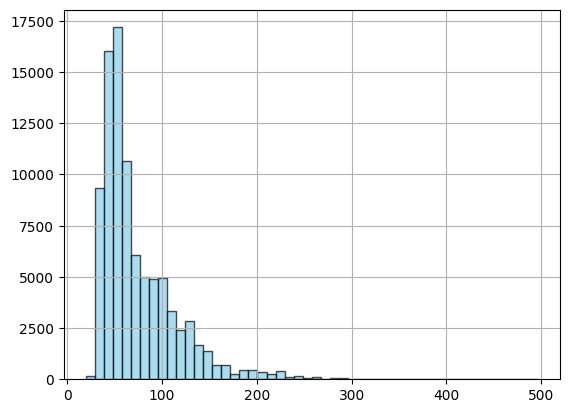

In [18]:
df.avg_mo_price_by_grade_set.loc[df.avg_mo_price_by_grade_set<500].hist(bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# Combine binary features to composite features using heuristic simple logic
- iterate and optimize on these

In [19]:
#df['rarity_score'] = df[['is_secret', 'is_full_art', 'is_legendary']].sum(axis=1)
#df['popularity_score'] = df[['is_eeveelution', 'is_og_char', 'is_gallery']].sum(axis=1)
df['ir_score'] = df.apply(lambda row: 3 if row['is_sir'] else (1 if row['is_ir'] else 0), axis=1)

# Assign integer grades to all cards

In [20]:
grade_mapping = {
    'nearmint': 8,
    'psa_10': 10,
    'psa_9': 9,
    'bgs_9_half': 9.5,
    'psa_8': 8,
    'psa_7': 7
}

df['num_grade'] = df['grade'].map(grade_mapping)

# Categorize Grade

In [21]:
def categorize_grade(grade):
    if grade == 10:
        return 1  # Highest value (Grade 10)
    elif grade >= 8:
        return 2  # Middle value (Grade 8-9)
    else:
        return 3  # Lower value (below Grade 8)

df['grade_category'] = df['num_grade'].apply(categorize_grade)

In [22]:
df["grade_category"].value_counts()

grade_category
2    52494
1    33966
3     3801
Name: count, dtype: int64

# Create column is_nearmint

In [23]:
df['is_near_mint_ungraded'] = (df['grade'] == 'nearmint').astype(int)

In [24]:
df.is_near_mint_ungraded.value_counts()

is_near_mint_ungraded
0    81668
1     8593
Name: count, dtype: int64

# Create column is_tag_team

In [25]:
df['is_tag_team'] = df['poke_name'].apply(lambda x: 1 if '&' in x and not any(sub in x for sub in ['chili', 'jesse', 'liza']) else 0)

# Create column is_alt_art

- Is price charting storing pokenumber numbers like SWSH162 Correctly?

In [26]:
from modules.config import alt_arts

In [27]:
def is_alt_art(row):
    poke_name = row['poke_name']
    poke_number = row['poke_no']
    
    for short_name, number in alt_arts.items():
        if short_name in poke_name and number == str(poke_number):
            return 1 
    return 0 

# Apply the function to create the new 'is_alt_art' column
df['is_alt_art'] = df.apply(is_alt_art, axis=1)

In [28]:
unique_alt_arts = len(df.loc[df.is_alt_art==1].drop_duplicates(subset=['poke_name', 'poke_no']))
print(f"{unique_alt_arts} alt art pokemon in dataset")
df.is_alt_art.value_counts()

65 alt art pokemon in dataset


is_alt_art
0    81765
1     8496
Name: count, dtype: int64

# Create time buckets

In [29]:
def categorize_months(months):
    if months>=12 and months <=24:
        return 'between_1_2_year'
    elif months>24:
        return 'over_2_year'

df['time_bucket'] = df['mos_since_release'].apply(categorize_months).astype(str)

In [30]:
df.time_bucket.value_counts()

time_bucket
over_2_year         57690
None                16574
between_1_2_year    15997
Name: count, dtype: int64

# OHE

In [31]:
df = pd.get_dummies(df, columns=['time_bucket'], drop_first=False)
df.loc[:, df.columns.str.startswith('time_bucket')] = df.loc[:, df.columns.str.startswith('time_bucket')].astype(int)
df.head(3)

C:\Users\huang\AppData\Local\Temp\ipykernel_22196\1363903450.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns.str.startswith('time_bucket')] = df.loc[:, df.columns.str.startswith('time_bucket')].astype(int)
C:\Users\huang\AppData\Local\Temp\ipykernel_22196\1363903450.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns.str.startswith('time_bucket')] = df.loc[:, df.columns.str.startswith('time_bucket')].astype(int)
C:\Users\huang\AppData\Local\Temp\ipykernel_22196\1363903450.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Va

,date,price,grade,poke_name,poke_no,set_name,product_type,set_year,set_month,execution_datetime,poke_id,card_type,release_date,mos_since_release,is_secret,is_full_art,is_full_art_secret,is_ir,is_sir,is_ultra_rare,is_shiny_rare,is_eeveelution,is_legendary,is_og_char,is_gallery,avg_mo_price_sealed_in_set,max_mo_price_sealed_in_set,avg_mo_price_card_in_set,max_mo_price_card_in_set,top10_nm_card_mo_sum_in_set,top10_nm_card_mo_avg_in_set,bb_mo_price_by_set,etb_mo_price_by_set,top10_mo_card_sum_to_bb_cost_ratio,avg_mo_price_psa_10_in_set,max_mo_price_psa_10_in_set,avg_mo_price_by_grade_set,ir_score,num_grade,grade_category,is_near_mint_ungraded,is_tag_team,is_alt_art,time_bucket_None,time_bucket_between_1_2_year,time_bucket_over_2_year
0,2021-09-01,61.0,psa_8,pikachu-vmax,44,vivid-voltage,card,2020,11,2024-11-07 00:50:40.190157,44vivid-voltage,NaN,2020-11-01,10,False,False,False,False,False,False,False,False,False,True,False,79.26,148.82,14.51,225.0,404.98,40.498,148.82,NaN,2.721274,105.05,667.50,54.100000,0,8.0,2,0,0,0,1,0,0
1,2021-10-01,61.0,psa_8,pikachu-vmax,44,vivid-voltage,card,2020,11,2024-11-07 00:50:40.190157,44vivid-voltage,NaN,2020-11-01,11,False,False,False,False,False,False,False,False,False,True,False,84.62,159.75,13.25,195.0,351.46,35.146,159.75,NaN,2.200063,96.76,632.95,52.956000,0,8.0,2,0,0,0,1,0,0
2,2021-11-01,49.0,psa_8,pikachu-vmax,44,vivid-voltage,card,2020,11,2024-11-07 00:50:40.190157,44vivid-voltage,NaN,2020-11-01,12,False,False,False,False,False,False,False,False,False,True,False,46.45,127.59,11.72,178.5,318.37,31.837,127.59,NaN,2.495258,87.41,597.50,49.615333,0,8.0,2,0,0,0,0,1,0


# Select features

In [32]:
df.columns

Index(['date', 'price', 'grade', 'poke_name', 'poke_no', 'set_name',
       'product_type', 'set_year', 'set_month', 'execution_datetime',
       'poke_id', 'card_type', 'release_date', 'mos_since_release',
       'is_secret', 'is_full_art', 'is_full_art_secret', 'is_ir', 'is_sir',
       'is_ultra_rare', 'is_shiny_rare', 'is_eeveelution', 'is_legendary',
       'is_og_char', 'is_gallery', 'avg_mo_price_sealed_in_set',
       'max_mo_price_sealed_in_set', 'avg_mo_price_card_in_set',
       'max_mo_price_card_in_set', 'top10_nm_card_mo_sum_in_set',
       'top10_nm_card_mo_avg_in_set', 'bb_mo_price_by_set',
       'etb_mo_price_by_set', 'top10_mo_card_sum_to_bb_cost_ratio',
       'avg_mo_price_psa_10_in_set', 'max_mo_price_psa_10_in_set',
       'avg_mo_price_by_grade_set', 'ir_score', 'num_grade', 'grade_category',
       'is_near_mint_ungraded', 'is_tag_team', 'is_alt_art',
       'time_bucket_None', 'time_bucket_between_1_2_year',
       'time_bucket_over_2_year'],
      dtype='obje

In [33]:
features = ["mos_since_release", 
            'num_grade',
            'is_secret', 
            'is_full_art', 
            'is_tag_team',
            'is_alt_art',
            'is_eeveelution', 
            'is_legendary',
            'is_og_char',
            'bb_mo_price_by_set', 
            'avg_mo_price_by_grade_set',
            'ir_score'
           ]

df[["poke_id"]+["poke_name"]+features+["price"]].head(3)

,poke_id,poke_name,mos_since_release,num_grade,is_secret,is_full_art,is_tag_team,is_alt_art,is_eeveelution,is_legendary,is_og_char,bb_mo_price_by_set,avg_mo_price_by_grade_set,ir_score,price
0,44vivid-voltage,pikachu-vmax,10,8.0,False,False,0,0,False,False,True,148.82,54.100000,0,61.0
1,44vivid-voltage,pikachu-vmax,11,8.0,False,False,0,0,False,False,True,159.75,52.956000,0,61.0
2,44vivid-voltage,pikachu-vmax,12,8.0,False,False,0,0,False,False,True,127.59,49.615333,0,49.0


# Corr matrix

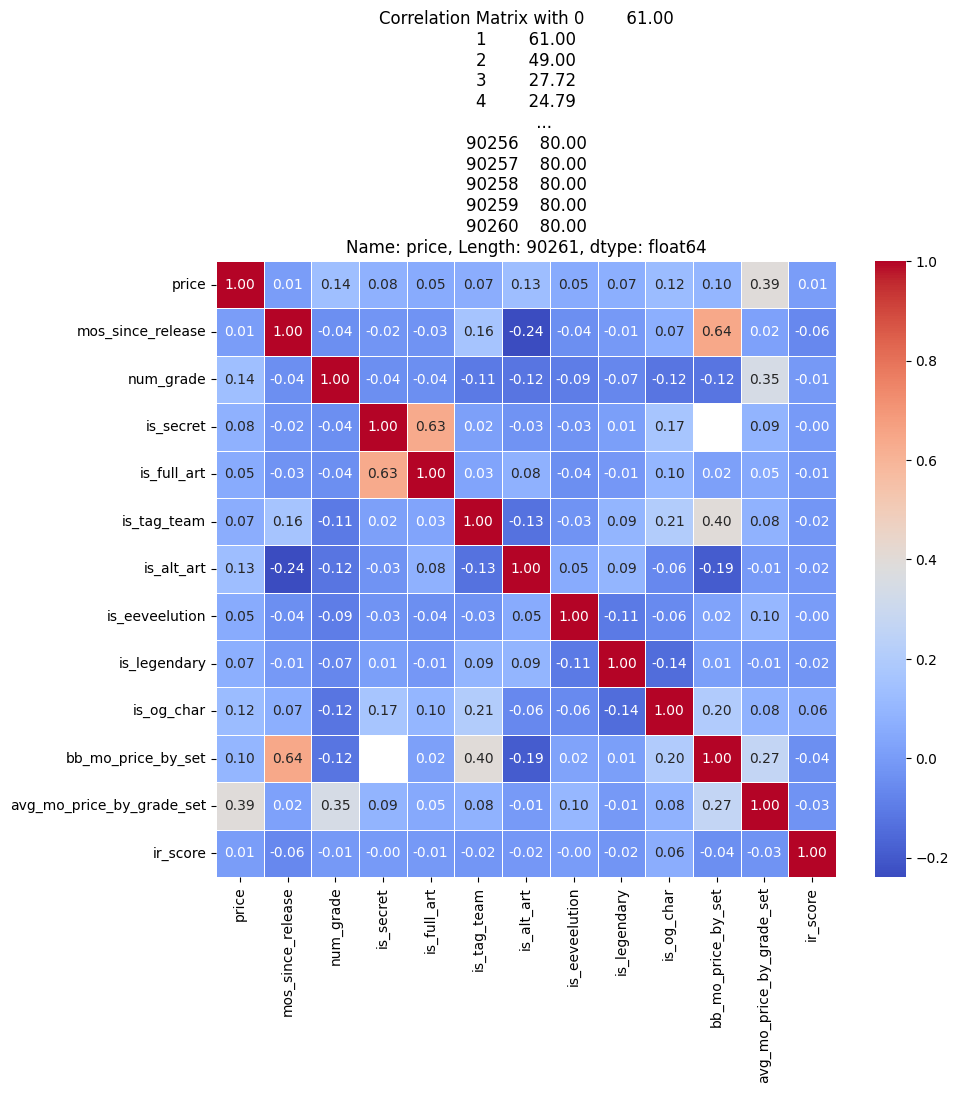

In [34]:
def plot_correlation_matrix(df, target_col):
    corr = df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix with {target_col}')
    plt.show()
    
plot_correlation_matrix(df[["price"]+features], df["price"])

# Train model

In [35]:
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)  # RMSE (Root Mean Squared Error)
    print(f'XGBoost model RMSE: {rmse:.4f}')
    return model

In [36]:
xgb_model = train_xgboost_model(df[features], df["price"])

XGBoost model RMSE: 92.6272


C:\Users\huang\OneDrive\Desktop\projects\poke_ai\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


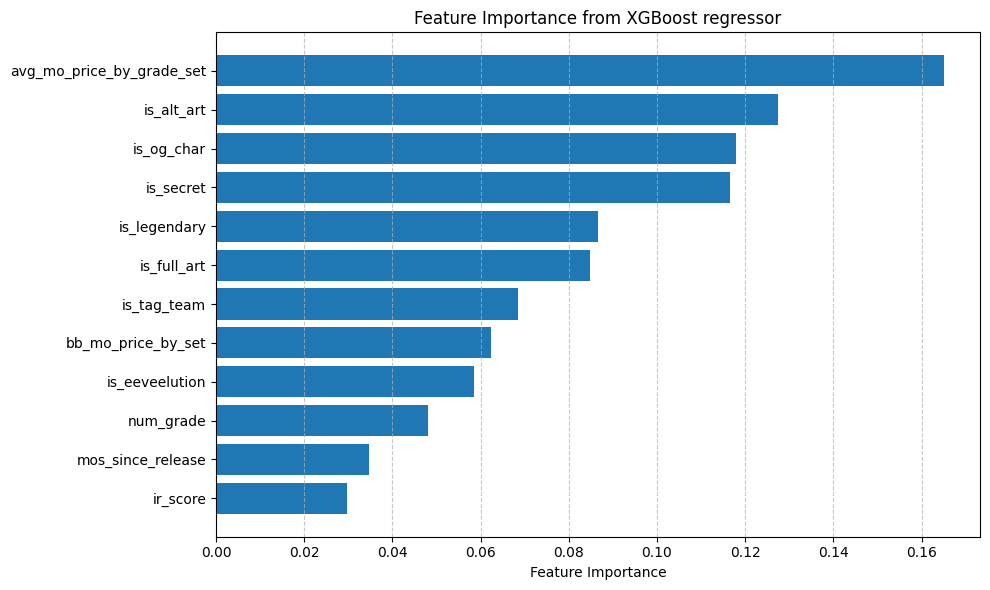

In [66]:
def plot_feature_importance(model, X):
    feature_importances = model.feature_importances_

    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
    plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance from XGBoost regressor")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

plot_feature_importance(xgb_model, df[features])

# Look at price distribution, clipped
- Around $60-80 avg

In [38]:
clipped = df.loc[df.price<=1000]
print(clipped.price.mean())
print(df.price.mean())

72.18889501781335
74.7995778907834


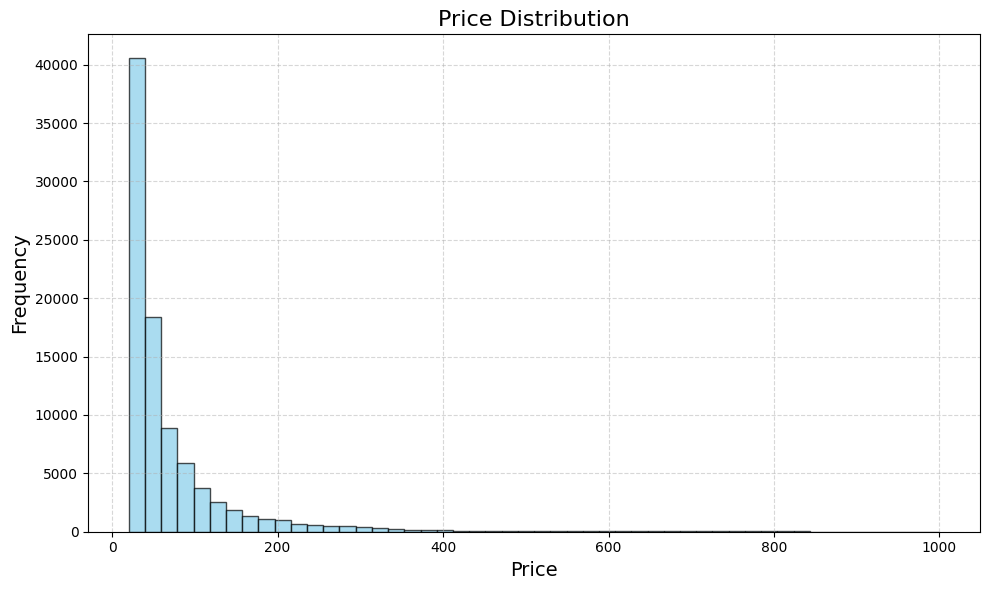

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(clipped["price"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

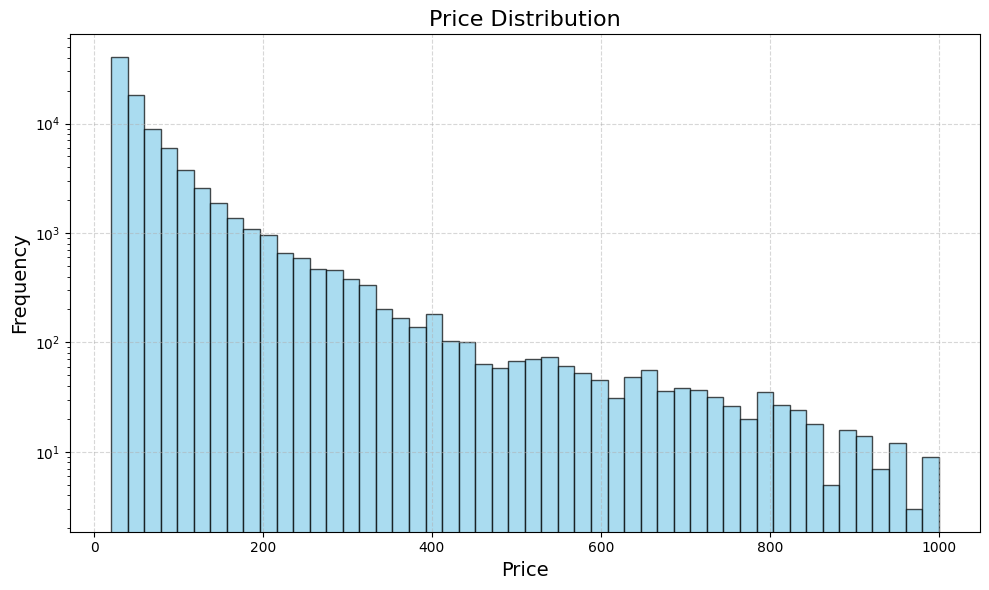

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(clipped["price"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale("log")
plt.tight_layout()

# GridSearch + CV

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [8,15],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse'),
                           param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(df[features], df["price"])
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}


In [43]:
# Best parameters and corresponding RMSE (calc from negative MSE)
print("Best parameters:", grid_search.best_params_)
best_score = np.sqrt(-grid_search.best_score_)  # Convert from negative MSE to RMSE
print("Best RMSE score:", best_score)

results = grid_search.cv_results_

results_df = pd.DataFrame(results)
results_df = results_df[['mean_test_score', 'std_test_score', 'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
results_df['mean_test_rmse'] = np.sqrt(-results_df['mean_test_score'])  # Convert MSE to RMSE
results_df['std_test_rmse'] = np.sqrt(results_df['std_test_score'])  # Convert std MSE to RMSE
results_df.sort_values(by="mean_test_rmse", ascending=True).head(5)

Best parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}
Best RMSE score: 104.70140121109725


,mean_test_score,std_test_score,param_learning_rate,param_max_depth,param_n_estimators,mean_test_rmse,std_test_rmse
0,-10962.383416,3867.834047,0.01,8,100,104.701401,62.191913
2,-11108.740653,3726.029433,0.01,15,100,105.398011,61.041211
1,-11285.520273,3771.793112,0.01,8,200,106.233329,61.414926
3,-11667.582836,3500.540327,0.01,15,200,108.016586,59.165364
4,-12113.741434,3688.382034,0.10,8,100,110.062443,60.732051


# Check under/overfit with best model

In [44]:
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)  # RMSE (Root Mean Squared Error)
    print(f'XGBoost model RMSE: {rmse:.4f}')
    return model

learning_rate=0.01, max_depth=5 to 7, n_estimators=150

In [67]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df["price"], test_size=0.2, random_state=42)


# Initialize XGBoost model with specified hyperparameters
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         eval_metric='rmse',
                         learning_rate=0.1, 
                         max_depth=9, 
                         n_estimators=100)

# Fit the model to the training data
model.fit(df[features], df["price"])

# Make predictions on both training and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate RMSE for training and validation sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"diff: {round(abs(train_rmse-val_rmse),2)}")

mean_price = df.price.mean()
std_dev = np.sqrt(df['price'].var())
print("\nMean Price is", mean_price, "with std_dev", std_dev)

Training RMSE: 84.2480
Validation RMSE: 83.2832
diff: 0.96

Mean Price is 74.7995778907834 with std_dev 109.53388087112378


# Test prediction

In [64]:
import numpy as np

def predict_card_price(model, test_features, feature_columns):
    test_features = pd.DataFrame([test_features], columns=feature_columns)
    
    predicted_price = model.predict(test_features)[0]
    
    return predicted_price

# Save TF Model

from datetime import datetime


current_datetime = datetime.now()
formatted_date = current_datetime.strftime('%m-%d-%Y')
model.save_model(f'my_model_{formatted_date}.bin')

- df['rarity_score'] = df[['is_secret', 'is_full_art', 'is_legendary']].sum(axis=1)
- df['popularity_score'] = df[['is_eeveelution', 'is_og_char', 'is_gallery']].sum(axis=1)
- df['ir_score'] = df.apply(lambda row: 3 if row['is_sir'] else (1 if row['is_ir'] else 0), axis=1)

# Formatted test payload

In [70]:
test_features = {
    "avg_mo_price_by_grade_set": 130, # re-work to be a more specific aggregate (by set as well)
    "mos_since_release": 13,
    'num_grade': 10,
    'is_secret': 0, 
    'is_alt_art': 1,
    'is_tag_team': 0,
    'is_full_art': 0, 
    'is_eeveelution': 0, 
    'is_legendary': 1,
    'is_og_char': 0,
    'ir_score': 0,
    'bb_mo_price_by_set': 322
}

predicted_price = predict_card_price(model, test_features, features)

print(f"Predicted price for the card: ${predicted_price:.2f}")

Predicted price for the card: $456.85


# How to prevent non-zero / non-negative / unrealistic price predictions? 
- give model more examples...
- handle with railguards post inference (step functions or rules to process model predictions and handle well)